In [1]:
# Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import VAR
!pip install vnstock
from vnstock import *

In [2]:
# Import data
VND = stock_historical_data(symbol = "VND", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(VND['Close']))
VND
#VND["Close"].plot()

Observations:  1629


,Open,High,Low,Close,Volume,Ticker
Time,,,,,,
2017-06-02,3230,3330,3200,3280,411631,VND
2017-06-05,3320,3370,3270,3280,671582,VND
2017-06-06,3280,3320,3270,3320,174560,VND
2017-06-07,3320,3610,3320,3590,2332950,VND
2017-06-08,3640,3640,3510,3540,467477,VND
...,...,...,...,...,...,...
2023-12-11,21700,22050,21400,21950,24142900,VND
2023-12-12,22000,22300,22000,22050,16260700,VND
2023-12-13,22250,22350,21500,21600,21677300,VND


In [3]:
# Preprocessing
scaler = MinMaxScaler(feature_range=(0,1))
def preprocessing(data):
    df = data[["Close", "Volume"]]
    df = df.reset_index(drop = True)
    df['Close'] = scaler.fit_transform(np.array(df['Close']).reshape(-1,1))
    df['Volume'] = scaler.transform(np.array(df['Volume']).reshape(-1,1))
    print(df)
    return df

def SplitSet73(data):
    train_size = int(0.7*len(data))
    test_size = int(0.3*len(data))
    train_data = data[:train_size]
    test_data = data[train_size:]
    print("Train data:\n", train_data.shape)
    print("Test data: \n", test_data.shape)
    return train_size, test_size, train_data, test_data


In [4]:
df = preprocessing(VND)

         Close       Volume
0     0.023256    12.685302
1     0.023256    20.745798
2     0.024496     5.334264
3     0.032868    72.261085
4     0.031318    14.416961
...        ...          ...
1624  0.602171   748.538605
1625  0.605271   504.129302
1626  0.591318   672.085891
1627  0.586667   554.730853
1628  0.597519  1177.924651

[1629 rows x 2 columns]


In [5]:
train_size = int(0.8*len(df))
test_size = int(0.2*len(df))
train_data = df[:train_size]
test_data = df[train_size:]
print("Train data:\n", train_data.shape)
print("Test data: \n", test_data.shape)

Train data:
 (1303, 2)
Test data: 
 (326, 2)


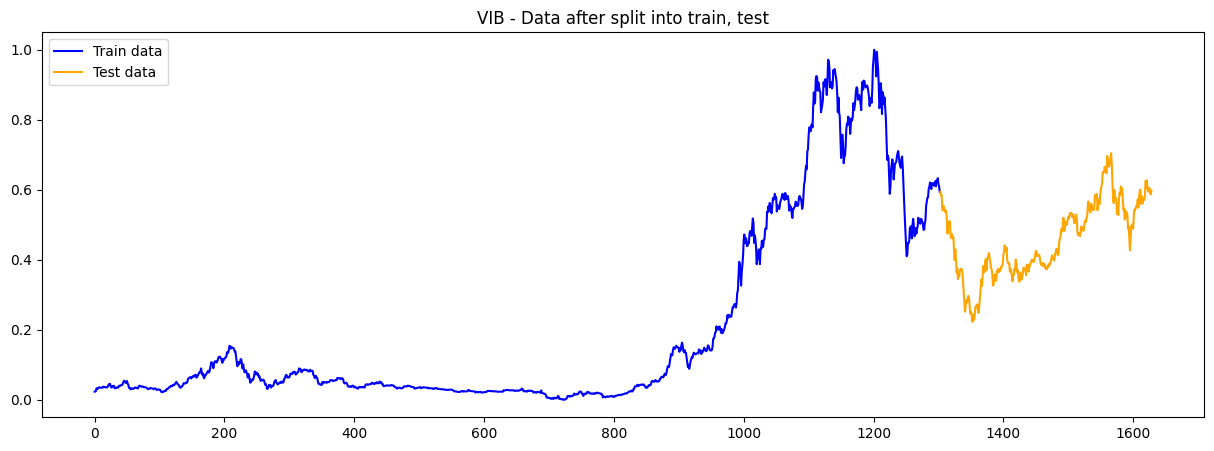

In [6]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Close'], 'b')
plt.plot(test_data.index, test_data['Close'], 'orange')
plt.legend(['Train data', 'Test data'], loc='upper left')
plt.title('VIB - Data after split into train, test')
plt.show()

In [7]:
model_var = VAR(train_data)
for i in range(1,10):
    results = model_var.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  0.21086748549383597
BIC:  0.2347000054144282

Order = 2
AIC:  0.05682720148285331
BIC:  0.09657269324697709

Order = 3
AIC:  -0.008299919730506668
BIC:  0.0473782907374124

Order = 4
AIC:  -0.03489528669588188
BIC:  0.036735429470454384

Order = 5
AIC:  -0.045224956575415386
BIC:  0.042378092530754696

Order = 6
AIC:  -0.047293048039445104
BIC:  0.05630220160760774

Order = 7
AIC:  -0.0529158613467131
BIC:  0.06669149691514384

Order = 8
AIC:  -0.06794820744982716
BIC:  0.06769120808727222

Order = 9
AIC:  -0.061896244622812936
BIC:  0.08979521755053493



In [8]:
result = model_var.fit(4)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 31, Dec, 2023
Time:                     03:39:29
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  0.0367354
Nobs:                     1299.00    HQIC:               -0.00801820
Log likelihood:          -3645.74    FPE:                   0.965707
AIC:                   -0.0348953    Det(Omega_mle):        0.952463
--------------------------------------------------------------------
Results for equation Close
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000416         0.000456            0.911           0.362
L1.Close          1.100749         0.027852           39.521           0.000
L1.Volume         0.000012         0.000005            2.485           0.013

In [9]:
lags_order = result.k_ar
lags_order

4

In [10]:
#Predict the price
y_pred_test = []
for i in range(test_data.shape[0] - lags_order):
    forecast_input = test_data[i:(i+lags_order)].values
    pred = result.forecast(forecast_input, steps=1)
    y_pred_test.append(list(pred[0]))

y_pred_test_price = np.array(scaler.inverse_transform(np.array(y_pred_test).transpose()[0].reshape(-1, 1)))
y_pred_test_vol = np.array(scaler.inverse_transform(np.array(y_pred_test).transpose()[1].reshape(-1, 1)))
y_pred_test_price.shape

(322, 1)

In [11]:
number_of_days_to_predict = 60

In [12]:
ndays_pred = result.forecast(df[-lags_order-number_of_days_to_predict:-number_of_days_to_predict].values, steps=number_of_days_to_predict)
ndays_pred = np.array(ndays_pred)[:, 0]
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))

ndays_pred.shape

(60, 1)

In [13]:
y_test = test_data['Close'].values[lags_order:]
y_test = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
y_test.shape

(322, 1)

In [14]:
def RSME (data1, data2):
    return np.sqrt(np.mean((data1-data2)*(data1-data2)))
def MAE (data1, data2):
    return np.mean(np.absolute(data1-data2))
def MAPE (pred, actual):
    return np.mean(np.absolute((pred-actual)/actual))*100
def MSLE (pred, actual):
    return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))

print("RSME test :", RSME(y_pred_test_price, y_test))
print("MAE test : ", MAE(y_pred_test_price, y_test))
print("MAPE test: ", MAPE(y_pred_test_price, y_test))
print("MSLR test: ", MSLE(y_pred_test_price, y_test))

RSME test : 628.542179811574
MAE test :  483.93254506100857
MAPE test:  2.8730711347966036
MSLR test:  0.0013492486458016326


In [15]:
lags = lags_order - 1

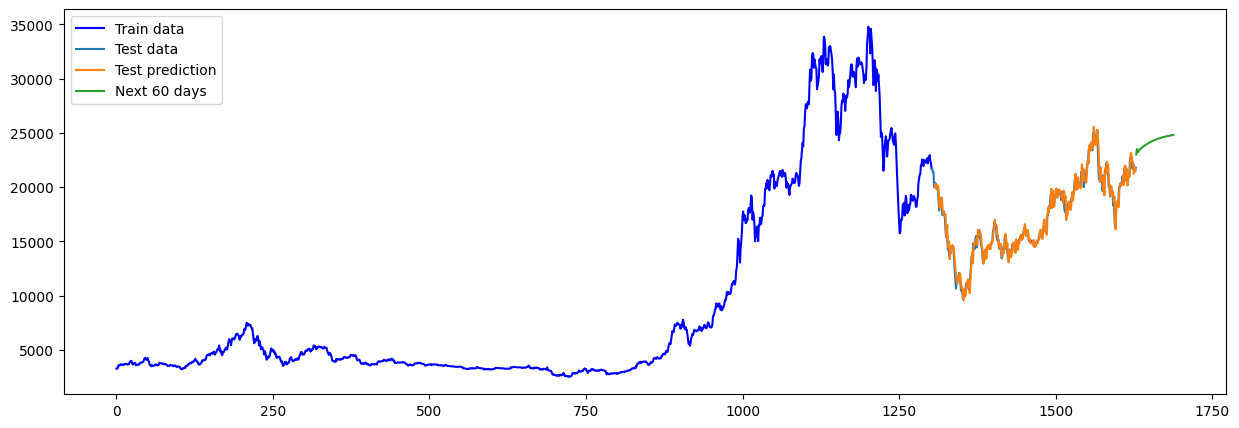

In [16]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, scaler.inverse_transform(np.array(train_data['Close']).reshape(-1, 1)), color="blue")
plt.plot(test_data.index, scaler.inverse_transform(np.array(test_data['Close']).reshape(-1, 1)).reshape(-1, 1))
plt.plot(test_data.index[-len(y_pred_test_price):], y_pred_test_price)
pred_ind = pd.RangeIndex(start = len(df['Close']), stop = len(df['Close'])+60)
plt.plot(pred_ind, ndays_pred)

plt.legend(["Train data", "Test data", "Test prediction", "Next 60 days"], loc = 'upper left')
plt.show()